### This notebook shows how to 

In [1]:
import os
from fabrictestbed.slice_manager import SliceManager, Status
import json

In [2]:
credmgr_host = os.environ['FABRIC_CREDMGR_HOST']
orchestrator_host = os.environ['FABRIC_ORCHESTRATOR_HOST']
print(f"CM Host: {credmgr_host} Orchestrator Host: {orchestrator_host}")

CM Host: beta-2.fabric-testbed.net Orchestrator Host: beta-7.fabric-testbed.net


## Create Slice Manager Object
Users can request tokens with different Project and Scopes by altering `project_name` and `scope` parameters in the refresh call below.

In [3]:
slice_manager = SliceManager(oc_host=orchestrator_host, cm_host=credmgr_host, project_name='all', scope='all')

# Initialize the slice manager
slice_manager.initialize()

### Orchestrator API example to query for available resources

In [31]:
status, advertised_topology = slice_manager.resources()

print(f"Status: {status}")
if status == Status.OK:
    print(f"Toplogy: {advertised_topology}")
else:
    print(f"Error: {advertised_topology}")

Status: Status.OK
Toplogy: UKY: { cpu: 6/6 , core: 178/192 , ram: 1,494/1,536 G, disk: 9,530/9,600 G, unit: 3/3 }
	Components:
		GPU-RTX6000:  GPU RTX6000 { unit: 2/2 }
		GPU-Tesla T4:  GPU Tesla T4 { unit: 4/4 }
		NVME-P4510:  NVME P4510 { disk: 6,000/10,000 G, unit: 6/10 }
		SharedNIC-ConnectX-6:  SharedNIC ConnectX-6 { unit: 377/381 }
		SmartNIC-ConnectX-6:  SmartNIC ConnectX-6 { unit: 0/2 }
		SmartNIC-ConnectX-5:  SmartNIC ConnectX-5 { unit: 2/2 }
	Site Interfaces:
		UKY_LBNL: TrunkPort { bw: 100/100 Gbps}
RENC
	Components:
	Site Interfaces:
STAR
	Components:
	Site Interfaces:
LBNL: { cpu: 6/6 , core: 184/192 , ram: 1,498/1,536 G, disk: 9,470/9,600 G, unit: 3/3 }
	Components:
		SharedNIC-ConnectX-6:  SharedNIC ConnectX-6 { unit: 378/381 }
		NVME-P4510:  NVME P4510 { disk: 9,000/10,000 G, unit: 9/10 }
		GPU-RTX6000:  GPU RTX6000 { unit: 2/2 }
		GPU-Tesla T4:  GPU Tesla T4 { unit: 4/4 }
		SmartNIC-ConnectX-6:  SmartNIC ConnectX-6 { unit: 2/2 }
		SmartNIC-ConnectX-5:  SmartNIC Connect

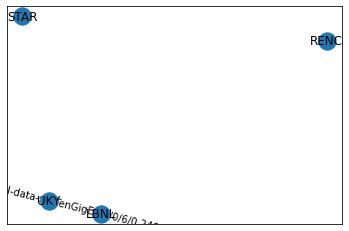

In [5]:
if status == Status.OK:
    advertised_topology.draw()

## Create Slice

We will request two nodes. We will attach a smart NIC to one of them, and a shared NIC to the other. Configurations for the NICs are going to be different.

The setup is shown below:

<img src="l2bridge-tagged-multiple-tags.png">

In [32]:
from fabrictestbed.slice_editor import ExperimentTopology, Capacities, ComponentType, ComponentModelType, ServiceType
# Create topology
t = ExperimentTopology()

# Add node
n1 = t.add_node(name='n1', site='LBNL')

# Set capacities
cap = Capacities()
cap.set_fields(core=2, ram=6, disk=10)

# Set Properties
n1.set_properties(capacities=cap, image_type='qcow2', image_ref='default_ubuntu_20')

# Add PCI devices
n1.add_component(ctype=ComponentType.NVME, model='P4510', name='c1')

# Add node
n2 = t.add_node(name='n2', site='LBNL')

# Set properties
n2.set_properties(capacities=cap, image_type='qcow2', image_ref='default_ubuntu_20')

# Add node
n3 = t.add_node(name='n3', site='LBNL')

# Set properties
n3.set_properties(capacities=cap, image_type='qcow2', image_ref='default_ubuntu_20')


n1.add_component(model_type=ComponentModelType.SmartNIC_ConnectX_6, name='n1-nic1')
n2.add_component(model_type=ComponentModelType.SmartNIC_ConnectX_6, name='n2-nic1')
n3.add_component(model_type=ComponentModelType.SmartNIC_ConnectX_5, name='n3-nic1')


interfaces_list = []
# For Tagged Bridge, specify VLAN
for i in t.interface_list:
#     print(i.name)
    include = False
    tag = ""
    if(i.name == 'n1-nic1-p1'):
        tag = "200"
    if(i.name == 'n2-nic1-p1'):
        tag = "200"
    if(i.name == 'n2-nic1-p2'):
        tag = "201"
    if(i.name == 'n3-nic1-p1'):
        tag = "201"
    if(i.name in ['n1-nic1-p1', 'n2-nic1-p1', 'n2-nic1-p2', 'n3-nic1-p1']):
        include = True
    if_labels = i.get_property(pname="labels")
    if_labels.vlan = tag
    i.set_properties(labels=if_labels)
    
    if(include):
        interfaces_list.append(i)

interfaces_tuple = tuple(interfaces_list)
    
# L2Bridge Service
t.add_network_service(name='bridge1', nstype=ServiceType.L2Bridge, interfaces=interfaces_tuple)

# Generate Slice Graph
slice_graph = t.serialize()

# print(interfaces_tuple)

ssh_key = None
with open ("/home/fabric/.ssh/id_rsa.pub", "r") as myfile:
    ssh_key=myfile.read()
    ssh_key=ssh_key.strip()

# Request slice from Orchestrator
status, reservations = slice_manager.create(slice_name='Slice-l2bridge-ded-multiple-tags', slice_graph=slice_graph, ssh_key=ssh_key)

print("Response Status {}".format(status))
if status == Status.OK:
    print("Reservations created {}".format(reservations))
else:
    print(f"Failure: {reservations}")

Response Status Status.OK
Reservations created [{
    "graph_node_id": "9f952ac5-6330-4fae-a62b-b8304b759429",
    "lease_end": "2021-08-12 22:53:56",
    "pending_state": "None_",
    "reservation_id": "ee4a88cf-e76b-4e82-acdc-1ec6f568dc84",
    "reservation_state": "Unknown",
    "slice_id": "589419b1-1311-44b0-b1da-dd9c863c6ebc"
}, {
    "graph_node_id": "54e258a4-57a4-4f39-a805-c7f52e3b0ea5",
    "lease_end": "2021-08-12 22:53:56",
    "pending_state": "None_",
    "reservation_id": "cf09c1e2-0d64-4991-be2b-95d460332655",
    "reservation_state": "Unknown",
    "slice_id": "589419b1-1311-44b0-b1da-dd9c863c6ebc"
}, {
    "graph_node_id": "3598b8b4-0433-42fa-b339-5744097e7609",
    "lease_end": "2021-08-12 22:53:56",
    "pending_state": "None_",
    "reservation_id": "293f05dd-dfeb-4b86-a367-aa301ad36d4f",
    "reservation_state": "Unknown",
    "slice_id": "589419b1-1311-44b0-b1da-dd9c863c6ebc"
}, {
    "graph_node_id": "a8f0662c-05c6-4036-b9af-93ae343167bb",
    "lease_end": "2021

In [33]:
# Set the Slice ID from output of the above command
slice_id=reservations[0].slice_id

## Query Slices

In [37]:
status, slices = slice_manager.slices() #(state="All")

print("Response Status {}".format(status))
if status == Status.OK:
    print("Slices {}".format(slices))
else:
    print(f"Failure: {slices}")

Response Status Status.OK
Slices [{
    "graph_id": "e1e7e503-f92d-438f-8d1e-81294519594c",
    "lease_end": "2021-08-12 22:53:56",
    "slice_id": "589419b1-1311-44b0-b1da-dd9c863c6ebc",
    "slice_name": "Slice-l2bridge-ded-multiple-tags",
    "slice_state": "StableOK"
}]


## Query Slivers

In [36]:
status, slivers = slice_manager.slivers(slice_id=slice_id)

print("Response Status {}".format(status))
if status == Status.OK:
    print("Slivers {}".format(slivers))
else:
    print(f"Failure: {slivers}")

Response Status Status.OK
Slivers [{
    "allocated_capacities": "{\"core\": 2, \"disk\": 10, \"ram\": 8}",
    "allocated_labels": "{\"instance\": \"instance-000000f7\", \"instance_parent\": \"lbnl-w2.fabric-testbed.net\"}",
    "capacities": "{\"core\": 2, \"disk\": 10, \"ram\": 6}",
    "capacity_hints": "{\"instance_type\": \"fabric.c2.m8.d10\"}",
    "graph_node_id": "54e258a4-57a4-4f39-a805-c7f52e3b0ea5",
    "join_state": "NoJoin",
    "lease_end": "2021-08-12 22:53:56",
    "management_ip": "198.129.61.50",
    "name": "n2",
    "pending_state": "None_",
    "reservation_id": "cf09c1e2-0d64-4991-be2b-95d460332655",
    "reservation_state": "Active",
    "resource_type": "VM",
    "site": "LBNL",
    "slice_id": "589419b1-1311-44b0-b1da-dd9c863c6ebc"
}, {
    "allocated_capacities": "{\"core\": 2, \"disk\": 10, \"ram\": 8}",
    "allocated_labels": "{\"instance\": \"instance-000000f8\", \"instance_parent\": \"lbnl-w2.fabric-testbed.net\"}",
    "capacities": "{\"core\": 2, \"dis

### Now let's connect to the nodes with paramiko.

In [20]:
import paramiko

In [39]:
client1_ip = slivers[1].management_ip
client1_ip

'198.129.61.53'

In [38]:
client2_ip = slivers[0].management_ip
client2_ip

'198.129.61.50'

In [40]:
client3_ip = slivers[3].management_ip
client3_ip

'198.129.61.61'

In [41]:
key = paramiko.RSAKey.from_private_key_file("/home/fabric/.ssh/id_rsa")
client1 = paramiko.SSHClient()
client1.load_system_host_keys()
client1.set_missing_host_key_policy(paramiko.MissingHostKeyPolicy())

client1.set_missing_host_key_policy(paramiko.AutoAddPolicy())
client1.connect(client1_ip,username='ubuntu',pkey = key)

client1

In [42]:
stdin, stdout, stderr = client1.exec_command('lsb_release -a')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Distributor ID:	Ubuntu
Description:	Ubuntu 20.04.2 LTS
Release:	20.04
Codename:	focal

No LSB modules are available.



In [43]:
key = paramiko.RSAKey.from_private_key_file("/home/fabric/.ssh/id_rsa")
client2 = paramiko.SSHClient()
client2.load_system_host_keys()
client2.set_missing_host_key_policy(paramiko.MissingHostKeyPolicy())

client2.set_missing_host_key_policy(paramiko.AutoAddPolicy())
client2.connect(client2_ip,username='ubuntu',pkey = key)

client2

In [44]:
stdin, stdout, stderr = client2.exec_command('lsb_release -a')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Distributor ID:	Ubuntu
Description:	Ubuntu 20.04.2 LTS
Release:	20.04
Codename:	focal

No LSB modules are available.



In [45]:
key = paramiko.RSAKey.from_private_key_file("/home/fabric/.ssh/id_rsa")
client3 = paramiko.SSHClient()
client3.load_system_host_keys()
client3.set_missing_host_key_policy(paramiko.MissingHostKeyPolicy())

client3.set_missing_host_key_policy(paramiko.AutoAddPolicy())
client3.connect(client3_ip,username='ubuntu',pkey = key)

client3

In [46]:
stdin, stdout, stderr = client3.exec_command('lsb_release -a')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Distributor ID:	Ubuntu
Description:	Ubuntu 20.04.2 LTS
Release:	20.04
Codename:	focal

No LSB modules are available.



### Let's try to let the nodes ping each other through their management IPs.

In [47]:
stdin, stdout, stderr = client1.exec_command('ping -c 5 ' + client2_ip)
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 198.129.61.50 (198.129.61.50) 56(84) bytes of data.
64 bytes from 198.129.61.50: icmp_seq=1 ttl=63 time=0.412 ms
64 bytes from 198.129.61.50: icmp_seq=2 ttl=63 time=0.252 ms
64 bytes from 198.129.61.50: icmp_seq=3 ttl=63 time=0.292 ms
64 bytes from 198.129.61.50: icmp_seq=4 ttl=63 time=0.299 ms
64 bytes from 198.129.61.50: icmp_seq=5 ttl=63 time=0.275 ms

--- 198.129.61.50 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4100ms
rtt min/avg/max/mdev = 0.252/0.306/0.412/0.055 ms




In [48]:
stdin, stdout, stderr = client1.exec_command('ping -c 5 ' + client3_ip)
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 198.129.61.61 (198.129.61.61) 56(84) bytes of data.
64 bytes from 198.129.61.61: icmp_seq=1 ttl=63 time=0.489 ms
64 bytes from 198.129.61.61: icmp_seq=2 ttl=63 time=0.260 ms
64 bytes from 198.129.61.61: icmp_seq=3 ttl=63 time=0.292 ms
64 bytes from 198.129.61.61: icmp_seq=4 ttl=63 time=0.296 ms
64 bytes from 198.129.61.61: icmp_seq=5 ttl=63 time=0.346 ms

--- 198.129.61.61 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4075ms
rtt min/avg/max/mdev = 0.260/0.336/0.489/0.081 ms




In [49]:
stdin, stdout, stderr = client2.exec_command('ping -c 5 ' + client1_ip)
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 198.129.61.53 (198.129.61.53) 56(84) bytes of data.
64 bytes from 198.129.61.53: icmp_seq=1 ttl=63 time=0.303 ms
64 bytes from 198.129.61.53: icmp_seq=2 ttl=63 time=0.213 ms
64 bytes from 198.129.61.53: icmp_seq=3 ttl=63 time=0.328 ms
64 bytes from 198.129.61.53: icmp_seq=4 ttl=63 time=0.251 ms
64 bytes from 198.129.61.53: icmp_seq=5 ttl=63 time=0.267 ms

--- 198.129.61.53 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4099ms
rtt min/avg/max/mdev = 0.213/0.272/0.328/0.040 ms




In [50]:
stdin, stdout, stderr = client2.exec_command('ping -c 5 ' + client3_ip)
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 198.129.61.61 (198.129.61.61) 56(84) bytes of data.
64 bytes from 198.129.61.61: icmp_seq=1 ttl=63 time=0.468 ms
64 bytes from 198.129.61.61: icmp_seq=2 ttl=63 time=0.372 ms
64 bytes from 198.129.61.61: icmp_seq=3 ttl=63 time=0.308 ms
64 bytes from 198.129.61.61: icmp_seq=4 ttl=63 time=0.274 ms
64 bytes from 198.129.61.61: icmp_seq=5 ttl=63 time=0.325 ms

--- 198.129.61.61 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4073ms
rtt min/avg/max/mdev = 0.274/0.349/0.468/0.067 ms




In [51]:
stdin, stdout, stderr = client3.exec_command('ping -c 5 ' + client1_ip)
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 198.129.61.53 (198.129.61.53) 56(84) bytes of data.
64 bytes from 198.129.61.53: icmp_seq=1 ttl=63 time=0.306 ms
64 bytes from 198.129.61.53: icmp_seq=2 ttl=63 time=0.361 ms
64 bytes from 198.129.61.53: icmp_seq=3 ttl=63 time=0.302 ms
64 bytes from 198.129.61.53: icmp_seq=4 ttl=63 time=0.296 ms
64 bytes from 198.129.61.53: icmp_seq=5 ttl=63 time=0.295 ms

--- 198.129.61.53 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4087ms
rtt min/avg/max/mdev = 0.295/0.312/0.361/0.024 ms




In [52]:
stdin, stdout, stderr = client3.exec_command('ping -c 5 ' + client2_ip)
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 198.129.61.50 (198.129.61.50) 56(84) bytes of data.
64 bytes from 198.129.61.50: icmp_seq=1 ttl=63 time=0.463 ms
64 bytes from 198.129.61.50: icmp_seq=2 ttl=63 time=0.357 ms
64 bytes from 198.129.61.50: icmp_seq=3 ttl=63 time=0.316 ms
64 bytes from 198.129.61.50: icmp_seq=4 ttl=63 time=0.300 ms
64 bytes from 198.129.61.50: icmp_seq=5 ttl=63 time=0.292 ms

--- 198.129.61.50 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4074ms
rtt min/avg/max/mdev = 0.292/0.345/0.463/0.062 ms




### We can see that the nodes are able to ping each other. This should be made possible by the control plane.

### We want to let the nodes communicate through the bridge that we have requested.

### To begin with, we will need to use the `route` command. So we need to install `net-tools`.

In [53]:
stdin, stdout, stderr = client1.exec_command('sudo apt update && sudo apt install net-tools')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))
stdin, stdout, stderr = client2.exec_command('sudo apt update && sudo apt install net-tools')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))
stdin, stdout, stderr = client3.exec_command('sudo apt update && sudo apt install net-tools')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Get:1 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:2 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [793 kB]
Get:3 http://security.ubuntu.com/ubuntu focal-security/main Translation-en [157 kB]
Get:4 http://security.ubuntu.com/ubuntu focal-security/main amd64 c-n-f Metadata [8424 B]
Get:5 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [330 kB]
Get:6 http://security.ubuntu.com/ubuntu focal-security/restricted Translation-en [47.6 kB]
Get:7 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 c-n-f Metadata [460 B]
Get:8 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [636 kB]
Get:9 http://security.ubuntu.com/ubuntu focal-security/universe Translation-en [98.9 kB]
Get:10 http://security.ubuntu.com/ubuntu focal-security/universe amd64 c-n-f Metadata [12.1 kB]
Get:11 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 Packages [22.3 kB]
Get:12 http://security.ubun

### Let's also install traceroute

In [100]:
stdin, stdout, stderr = client1.exec_command('sudo apt install traceroute')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))
stdin, stdout, stderr = client2.exec_command('sudo apt install traceroute')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))
stdin, stdout, stderr = client3.exec_command('sudo apt install traceroute')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Reading package lists...
Building dependency tree...
Reading state information...
The following NEW packages will be installed:
  traceroute
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 45.4 kB of archives.
After this operation, 152 kB of additional disk space will be used.
Get:1 http://nova.clouds.archive.ubuntu.com/ubuntu focal/universe amd64 traceroute amd64 1:2.1.0-2 [45.4 kB]
Fetched 45.4 kB in 1s (40.4 kB/s)
Selecting previously unselected package traceroute.
(Reading database ... 63576 files and directories currently installed.)
Preparing to unpack .../traceroute_1%3a2.1.0-2_amd64.deb ...
Unpacking traceroute (1:2.1.0-2) ...
Setting up traceroute (1:2.1.0-2) ...
update-alternatives: using /usr/bin/traceroute.db to provide /usr/bin/traceroute (traceroute) in auto mode
update-alternatives: using /usr/bin/lft.db to provide /usr/bin/lft (lft) in auto mode
update-alternatives: using /usr/bin/traceproto.db to provide /usr/bin/traceproto (traceproto) in a

### Let's look at the available interfaces.

In [54]:
stdin, stdout, stderr = client1.exec_command('ip a')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

1: lo: <LOOPBACK,UP,LOWER_UP> mtu 65536 qdisc noqueue state UNKNOWN group default qlen 1000
    link/loopback 00:00:00:00:00:00 brd 00:00:00:00:00:00
    inet 127.0.0.1/8 scope host lo
       valid_lft forever preferred_lft forever
    inet6 ::1/128 scope host 
       valid_lft forever preferred_lft forever
2: ens3: <BROADCAST,MULTICAST,UP,LOWER_UP> mtu 9000 qdisc fq_codel state UP group default qlen 1000
    link/ether fa:16:3e:b1:ef:9b brd ff:ff:ff:ff:ff:ff
    inet 10.20.4.178/24 brd 10.20.4.255 scope global dynamic ens3
       valid_lft 86106sec preferred_lft 86106sec
    inet6 fe80::f816:3eff:feb1:ef9b/64 scope link 
       valid_lft forever preferred_lft forever
3: ens8: <BROADCAST,MULTICAST> mtu 1500 qdisc noop state DOWN group default qlen 1000
    link/ether 04:3f:72:b7:15:8c brd ff:ff:ff:ff:ff:ff
4: ens9: <BROADCAST,MULTICAST> mtu 1500 qdisc noop state DOWN group default qlen 1000
    link/ether 04:3f:72:b7:15:8d brd ff:ff:ff:ff:ff:ff




In [55]:
stdin, stdout, stderr = client2.exec_command('ip a')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

1: lo: <LOOPBACK,UP,LOWER_UP> mtu 65536 qdisc noqueue state UNKNOWN group default qlen 1000
    link/loopback 00:00:00:00:00:00 brd 00:00:00:00:00:00
    inet 127.0.0.1/8 scope host lo
       valid_lft forever preferred_lft forever
    inet6 ::1/128 scope host 
       valid_lft forever preferred_lft forever
2: ens3: <BROADCAST,MULTICAST,UP,LOWER_UP> mtu 9000 qdisc fq_codel state UP group default qlen 1000
    link/ether fa:16:3e:0b:d3:0f brd ff:ff:ff:ff:ff:ff
    inet 10.20.4.233/24 brd 10.20.4.255 scope global dynamic ens3
       valid_lft 86102sec preferred_lft 86102sec
    inet6 fe80::f816:3eff:fe0b:d30f/64 scope link 
       valid_lft forever preferred_lft forever
3: ens7: <BROADCAST,MULTICAST> mtu 1500 qdisc noop state DOWN group default qlen 1000
    link/ether 04:3f:72:b7:18:ac brd ff:ff:ff:ff:ff:ff
4: ens8: <BROADCAST,MULTICAST> mtu 1500 qdisc noop state DOWN group default qlen 1000
    link/ether 04:3f:72:b7:18:ad brd ff:ff:ff:ff:ff:ff




In [57]:
stdin, stdout, stderr = client3.exec_command('ip a')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

1: lo: <LOOPBACK,UP,LOWER_UP> mtu 65536 qdisc noqueue state UNKNOWN group default qlen 1000
    link/loopback 00:00:00:00:00:00 brd 00:00:00:00:00:00
    inet 127.0.0.1/8 scope host lo
       valid_lft forever preferred_lft forever
    inet6 ::1/128 scope host 
       valid_lft forever preferred_lft forever
2: ens3: <BROADCAST,MULTICAST,UP,LOWER_UP> mtu 9000 qdisc fq_codel state UP group default qlen 1000
    link/ether fa:16:3e:87:a7:ca brd ff:ff:ff:ff:ff:ff
    inet 10.20.4.18/24 brd 10.20.4.255 scope global dynamic ens3
       valid_lft 86006sec preferred_lft 86006sec
    inet6 fe80::f816:3eff:fe87:a7ca/64 scope link 
       valid_lft forever preferred_lft forever
3: ens7: <BROADCAST,MULTICAST> mtu 1500 qdisc noop state DOWN group default qlen 1000
    link/ether 0c:42:a1:91:75:12 brd ff:ff:ff:ff:ff:ff
4: ens8: <BROADCAST,MULTICAST> mtu 1500 qdisc noop state DOWN group default qlen 1000
    link/ether 0c:42:a1:91:75:13 brd ff:ff:ff:ff:ff:ff




### All nodes have two network interfaces.

### Now, we need to remember that we have requested that

- `n1`'s first port (`ens8`) and `n2`'s first port (`ens7`) are in the same vlan which is tagged `200`
- `n2`'s second port (`ens8`) and `n3`'s first port (`ens7`) are in the same vlan which is tagged `201`

<hr>

### Now let's configure our interfaces.

### Let's begin by configuring `n1`'s NIC.

In [63]:
stdin, stdout, stderr = client1.exec_command('sudo ip link add link ens8 name ens8.200 type vlan id 200')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [64]:
stdin, stdout, stderr = client1.exec_command('sudo ip link set dev ens8 up')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [65]:
stdin, stdout, stderr = client1.exec_command('sudo ip link set dev ens8.200 up')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [66]:
stdin, stdout, stderr = client1.exec_command('sudo ip addr add 192.168.10.51/24 dev ens8.200')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

<hr>

### Now let's configure `n2`'s NIC.

<!-- ### We need to add a new interface that picks traffic tagged `200` (as we specified when we were creating the slice).

### We are going to create two "vlan" interfaces called `ens7.200` and `ens8.200`. They are going to pick traffic tagged `200` from their corresponding interfaces (`ens7` and `ens8` respectively).

### And then we will assign IP addresses to `ens7.200` and `ens8.200`. -->

In [67]:
stdin, stdout, stderr = client2.exec_command('sudo ip link add link ens7 name ens7.200 type vlan id 200')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [68]:
stdin, stdout, stderr = client2.exec_command('sudo ip link set dev ens7 up')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [69]:
stdin, stdout, stderr = client2.exec_command('sudo ip link set dev ens7.200 up')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [70]:
stdin, stdout, stderr = client2.exec_command('sudo ip addr add 192.168.10.52/24 dev ens7.200')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

<hr>

In [71]:
stdin, stdout, stderr = client2.exec_command('sudo ip link add link ens8 name ens8.201 type vlan id 201')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [72]:
stdin, stdout, stderr = client2.exec_command('sudo ip link set dev ens8 up')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [73]:
stdin, stdout, stderr = client2.exec_command('sudo ip link set dev ens8.201 up')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [74]:
stdin, stdout, stderr = client2.exec_command('sudo ip addr add 192.168.20.52/24 dev ens8.201')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

<hr>

### And finally, let's configure `n3`'s NICs.

In [75]:
stdin, stdout, stderr = client3.exec_command('sudo ip link add link ens7 name ens7.201 type vlan id 201')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [76]:
stdin, stdout, stderr = client3.exec_command('sudo ip link set dev ens7 up')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [77]:
stdin, stdout, stderr = client3.exec_command('sudo ip link set dev ens7.201 up')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [78]:
stdin, stdout, stderr = client3.exec_command('sudo ip addr add 192.168.20.53/24 dev ens7.201')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

### Next thing to do is add routes.
<!-- 
### For `n1`, we are going to direct traffic going to both `192.168.11.0` and `192.168.12.0` through `ens8` -->

### For `n1`

In [79]:
stdin, stdout, stderr = client1.exec_command('sudo route add -net 192.168.10.0/24 dev ens8.200')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

### For `n2`

<!-- we are going to direct traffic going to `192.168.10.0` through `ens7.200`. -->

In [80]:
stdin, stdout, stderr = client2.exec_command('sudo route add -net 192.168.10.0/24 dev ens7.200')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [81]:
stdin, stdout, stderr = client2.exec_command('sudo route add -net 192.168.20.0/24 dev ens8.201')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

### For `n3`

In [82]:
stdin, stdout, stderr = client3.exec_command('sudo route add -net 192.168.20.0/24 dev ens7.201')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

<hr>

### Now let's ping

In [86]:
stdin, stdout, stderr = client1.exec_command('ping -c 5 192.168.10.52')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 192.168.10.52 (192.168.10.52) 56(84) bytes of data.
64 bytes from 192.168.10.52: icmp_seq=1 ttl=64 time=0.245 ms
64 bytes from 192.168.10.52: icmp_seq=2 ttl=64 time=0.050 ms
64 bytes from 192.168.10.52: icmp_seq=3 ttl=64 time=0.062 ms
64 bytes from 192.168.10.52: icmp_seq=4 ttl=64 time=0.054 ms
64 bytes from 192.168.10.52: icmp_seq=5 ttl=64 time=0.049 ms

--- 192.168.10.52 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4097ms
rtt min/avg/max/mdev = 0.049/0.092/0.245/0.076 ms




In [87]:
stdin, stdout, stderr = client1.exec_command('ping -c 5 192.168.20.52')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 192.168.20.52 (192.168.20.52) 56(84) bytes of data.
From 198.129.61.126 icmp_seq=1 Destination Net Unreachable
From 198.129.61.126 icmp_seq=2 Destination Net Unreachable
From 198.129.61.126 icmp_seq=3 Destination Net Unreachable
From 198.129.61.126 icmp_seq=4 Destination Net Unreachable
From 198.129.61.126 icmp_seq=5 Destination Net Unreachable

--- 192.168.20.52 ping statistics ---
5 packets transmitted, 0 received, +5 errors, 100% packet loss, time 4098ms





In [88]:
stdin, stdout, stderr = client1.exec_command('ping -c 5 192.168.20.53')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 192.168.20.53 (192.168.20.53) 56(84) bytes of data.
From 198.129.61.126 icmp_seq=1 Destination Net Unreachable
From 198.129.61.126 icmp_seq=2 Destination Net Unreachable
From 198.129.61.126 icmp_seq=3 Destination Net Unreachable
From 198.129.61.126 icmp_seq=4 Destination Net Unreachable
From 198.129.61.126 icmp_seq=5 Destination Net Unreachable

--- 192.168.20.53 ping statistics ---
5 packets transmitted, 0 received, +5 errors, 100% packet loss, time 4074ms





### We can see above that client1 is able to talk to client2's first port only.

In [90]:
stdin, stdout, stderr = client2.exec_command('ping -c 5 192.168.10.51')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 192.168.10.51 (192.168.10.51) 56(84) bytes of data.
64 bytes from 192.168.10.51: icmp_seq=1 ttl=64 time=0.095 ms
64 bytes from 192.168.10.51: icmp_seq=2 ttl=64 time=0.066 ms
64 bytes from 192.168.10.51: icmp_seq=3 ttl=64 time=0.048 ms
64 bytes from 192.168.10.51: icmp_seq=4 ttl=64 time=0.053 ms
64 bytes from 192.168.10.51: icmp_seq=5 ttl=64 time=0.057 ms

--- 192.168.10.51 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4098ms
rtt min/avg/max/mdev = 0.048/0.063/0.095/0.016 ms




In [89]:
stdin, stdout, stderr = client2.exec_command('ping -c 5 192.168.20.53')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 192.168.20.53 (192.168.20.53) 56(84) bytes of data.
64 bytes from 192.168.20.53: icmp_seq=1 ttl=64 time=0.296 ms
64 bytes from 192.168.20.53: icmp_seq=2 ttl=64 time=0.060 ms
64 bytes from 192.168.20.53: icmp_seq=3 ttl=64 time=0.050 ms
64 bytes from 192.168.20.53: icmp_seq=4 ttl=64 time=0.079 ms
64 bytes from 192.168.20.53: icmp_seq=5 ttl=64 time=0.069 ms

--- 192.168.20.53 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4080ms
rtt min/avg/max/mdev = 0.050/0.110/0.296/0.093 ms




### We can see above that client2 can talk to client1's port and client3's port.

In [91]:
stdin, stdout, stderr = client3.exec_command('ping -c 5 192.168.20.52')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 192.168.20.52 (192.168.20.52) 56(84) bytes of data.
64 bytes from 192.168.20.52: icmp_seq=1 ttl=64 time=0.121 ms
64 bytes from 192.168.20.52: icmp_seq=2 ttl=64 time=0.064 ms
64 bytes from 192.168.20.52: icmp_seq=3 ttl=64 time=0.064 ms
64 bytes from 192.168.20.52: icmp_seq=4 ttl=64 time=0.052 ms
64 bytes from 192.168.20.52: icmp_seq=5 ttl=64 time=0.100 ms

--- 192.168.20.52 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4098ms
rtt min/avg/max/mdev = 0.052/0.080/0.121/0.026 ms




In [92]:
stdin, stdout, stderr = client3.exec_command('ping -c 5 192.168.10.52')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 192.168.10.52 (192.168.10.52) 56(84) bytes of data.
From 198.129.61.126 icmp_seq=1 Destination Net Unreachable
From 198.129.61.126 icmp_seq=2 Destination Net Unreachable
From 198.129.61.126 icmp_seq=3 Destination Net Unreachable
From 198.129.61.126 icmp_seq=4 Destination Net Unreachable
From 198.129.61.126 icmp_seq=5 Destination Net Unreachable

--- 192.168.10.52 ping statistics ---
5 packets transmitted, 0 received, +5 errors, 100% packet loss, time 4010ms





In [93]:
stdin, stdout, stderr = client3.exec_command('ping -c 5 192.168.10.51')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 192.168.10.51 (192.168.10.51) 56(84) bytes of data.
From 198.129.61.126 icmp_seq=1 Destination Net Unreachable
From 198.129.61.126 icmp_seq=2 Destination Net Unreachable
From 198.129.61.126 icmp_seq=3 Destination Net Unreachable
From 198.129.61.126 icmp_seq=4 Destination Net Unreachable
From 198.129.61.126 icmp_seq=5 Destination Net Unreachable

--- 192.168.10.51 ping statistics ---
5 packets transmitted, 0 received, +5 errors, 100% packet loss, time 4073ms





### We can see above that client3 can only talk to client2's second port.

<hr>

### Next, we'll let node 2 act as a router between nodes 1 and 3. This will let nodes 1 and 3 be able to reach each other through node 2.

### We need to:
- let nodes 1 and 3 route packets through the interfaces of the ports that we've already configured.
- let node 2 forward packets.

In [94]:
stdin, stdout, stderr = client1.exec_command('sudo ip route add 192.168.20.0/24 via 192.168.10.52')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [95]:
stdin, stdout, stderr = client3.exec_command('sudo ip route add 192.168.10.0/24 via 192.168.20.52')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [96]:
stdin, stdout, stderr = client2.exec_command('sudo sysctl -w net.ipv4.ip_forward=1')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

net.ipv4.ip_forward = 1




<hr>

### Now let's ping again.

In [97]:
stdin, stdout, stderr = client1.exec_command('ping -c 5 192.168.10.52')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 192.168.10.52 (192.168.10.52) 56(84) bytes of data.
64 bytes from 192.168.10.52: icmp_seq=1 ttl=64 time=0.133 ms
64 bytes from 192.168.10.52: icmp_seq=2 ttl=64 time=0.060 ms
64 bytes from 192.168.10.52: icmp_seq=3 ttl=64 time=0.056 ms
64 bytes from 192.168.10.52: icmp_seq=4 ttl=64 time=0.062 ms
64 bytes from 192.168.10.52: icmp_seq=5 ttl=64 time=0.079 ms

--- 192.168.10.52 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4072ms
rtt min/avg/max/mdev = 0.056/0.078/0.133/0.028 ms




In [98]:
stdin, stdout, stderr = client1.exec_command('ping -c 5 192.168.20.52')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 192.168.20.52 (192.168.20.52) 56(84) bytes of data.
64 bytes from 192.168.20.52: icmp_seq=1 ttl=64 time=0.062 ms
64 bytes from 192.168.20.52: icmp_seq=2 ttl=64 time=0.062 ms
64 bytes from 192.168.20.52: icmp_seq=3 ttl=64 time=0.067 ms
64 bytes from 192.168.20.52: icmp_seq=4 ttl=64 time=0.070 ms
64 bytes from 192.168.20.52: icmp_seq=5 ttl=64 time=0.071 ms

--- 192.168.20.52 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4099ms
rtt min/avg/max/mdev = 0.062/0.066/0.071/0.003 ms




In [99]:
stdin, stdout, stderr = client1.exec_command('ping -c 5 192.168.20.53')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 192.168.20.53 (192.168.20.53) 56(84) bytes of data.
64 bytes from 192.168.20.53: icmp_seq=1 ttl=63 time=0.282 ms
64 bytes from 192.168.20.53: icmp_seq=2 ttl=63 time=0.120 ms
64 bytes from 192.168.20.53: icmp_seq=3 ttl=63 time=0.108 ms
64 bytes from 192.168.20.53: icmp_seq=4 ttl=63 time=0.122 ms
64 bytes from 192.168.20.53: icmp_seq=5 ttl=63 time=0.128 ms

--- 192.168.20.53 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4100ms
rtt min/avg/max/mdev = 0.108/0.152/0.282/0.065 ms




### We can see that all network interfaces are now reachable.

### Now let's do a traceroute to see the path that the packets take.

In [101]:
stdin, stdout, stderr = client1.exec_command('traceroute 192.168.10.52')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

traceroute to 192.168.10.52 (192.168.10.52), 30 hops max, 60 byte packets
 1  192.168.10.52 (192.168.10.52)  0.160 ms  0.142 ms  0.135 ms




In [105]:
stdin, stdout, stderr = client1.exec_command('traceroute 192.168.20.52')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

traceroute to 192.168.20.52 (192.168.20.52), 30 hops max, 60 byte packets
 1  192.168.20.52 (192.168.20.52)  0.062 ms  0.073 ms  0.066 ms




In [103]:
stdin, stdout, stderr = client1.exec_command('traceroute 192.168.20.53')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

traceroute to 192.168.20.53 (192.168.20.53), 30 hops max, 60 byte packets
 1  * 192.168.10.52 (192.168.10.52)  0.070 ms *
 2  192.168.20.53 (192.168.20.53)  0.222 ms  0.215 ms  0.208 ms




### We can see that the two ports of client 2 are directly reachable, as if they are directly connected.

### And we can see that client 3 is reachable after one hop through client 2.

### Now let's look at the rest of the clients.

In [106]:
stdin, stdout, stderr = client2.exec_command('ping -c 5 192.168.10.51')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 192.168.10.51 (192.168.10.51) 56(84) bytes of data.
64 bytes from 192.168.10.51: icmp_seq=1 ttl=64 time=0.101 ms
64 bytes from 192.168.10.51: icmp_seq=2 ttl=64 time=0.065 ms
64 bytes from 192.168.10.51: icmp_seq=3 ttl=64 time=0.055 ms
64 bytes from 192.168.10.51: icmp_seq=4 ttl=64 time=0.073 ms
64 bytes from 192.168.10.51: icmp_seq=5 ttl=64 time=0.060 ms

--- 192.168.10.51 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4099ms
rtt min/avg/max/mdev = 0.055/0.070/0.101/0.016 ms




In [107]:
stdin, stdout, stderr = client2.exec_command('ping -c 5 192.168.20.53')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 192.168.20.53 (192.168.20.53) 56(84) bytes of data.
64 bytes from 192.168.20.53: icmp_seq=1 ttl=64 time=0.099 ms
64 bytes from 192.168.20.53: icmp_seq=2 ttl=64 time=0.072 ms
64 bytes from 192.168.20.53: icmp_seq=3 ttl=64 time=0.071 ms
64 bytes from 192.168.20.53: icmp_seq=4 ttl=64 time=0.059 ms
64 bytes from 192.168.20.53: icmp_seq=5 ttl=64 time=0.063 ms

--- 192.168.20.53 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4099ms
rtt min/avg/max/mdev = 0.059/0.072/0.099/0.014 ms




<hr>

In [108]:
stdin, stdout, stderr = client2.exec_command('traceroute 192.168.10.51')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

traceroute to 192.168.10.51 (192.168.10.51), 30 hops max, 60 byte packets
 1  192.168.10.51 (192.168.10.51)  0.073 ms  0.041 ms  0.092 ms




In [109]:
stdin, stdout, stderr = client2.exec_command('traceroute 192.168.20.53')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

traceroute to 192.168.20.53 (192.168.20.53), 30 hops max, 60 byte packets
 1  192.168.20.53 (192.168.20.53)  0.055 ms *  0.039 ms




<hr>

In [110]:
stdin, stdout, stderr = client3.exec_command('ping -c 5 192.168.20.52')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 192.168.20.52 (192.168.20.52) 56(84) bytes of data.
64 bytes from 192.168.20.52: icmp_seq=1 ttl=64 time=0.109 ms
64 bytes from 192.168.20.52: icmp_seq=2 ttl=64 time=0.062 ms
64 bytes from 192.168.20.52: icmp_seq=3 ttl=64 time=0.065 ms
64 bytes from 192.168.20.52: icmp_seq=4 ttl=64 time=0.122 ms
64 bytes from 192.168.20.52: icmp_seq=5 ttl=64 time=0.075 ms

--- 192.168.20.52 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4074ms
rtt min/avg/max/mdev = 0.062/0.086/0.122/0.024 ms




In [111]:
stdin, stdout, stderr = client3.exec_command('ping -c 5 192.168.10.52')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 192.168.10.52 (192.168.10.52) 56(84) bytes of data.
64 bytes from 192.168.10.52: icmp_seq=1 ttl=64 time=0.074 ms
64 bytes from 192.168.10.52: icmp_seq=2 ttl=64 time=0.059 ms
64 bytes from 192.168.10.52: icmp_seq=3 ttl=64 time=0.051 ms
64 bytes from 192.168.10.52: icmp_seq=4 ttl=64 time=0.051 ms
64 bytes from 192.168.10.52: icmp_seq=5 ttl=64 time=0.062 ms

--- 192.168.10.52 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4078ms
rtt min/avg/max/mdev = 0.051/0.059/0.074/0.008 ms




In [112]:
stdin, stdout, stderr = client3.exec_command('ping -c 5 192.168.10.51')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 192.168.10.51 (192.168.10.51) 56(84) bytes of data.
64 bytes from 192.168.10.51: icmp_seq=1 ttl=63 time=0.255 ms
64 bytes from 192.168.10.51: icmp_seq=2 ttl=63 time=0.128 ms
64 bytes from 192.168.10.51: icmp_seq=3 ttl=63 time=0.140 ms
64 bytes from 192.168.10.51: icmp_seq=4 ttl=63 time=0.140 ms
64 bytes from 192.168.10.51: icmp_seq=5 ttl=63 time=0.189 ms

--- 192.168.10.51 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4104ms
rtt min/avg/max/mdev = 0.128/0.170/0.255/0.047 ms




In [113]:
stdin, stdout, stderr = client3.exec_command('traceroute 192.168.20.52')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

traceroute to 192.168.20.52 (192.168.20.52), 30 hops max, 60 byte packets
 1  192.168.20.52 (192.168.20.52)  0.073 ms  0.063 ms  0.057 ms




In [116]:
stdin, stdout, stderr = client3.exec_command('traceroute 192.168.10.52')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

traceroute to 192.168.10.52 (192.168.10.52), 30 hops max, 60 byte packets
 1  192.168.10.52 (192.168.10.52)  0.069 ms  0.056 ms  0.044 ms




In [117]:
stdin, stdout, stderr = client3.exec_command('traceroute 192.168.10.51')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

traceroute to 192.168.10.51 (192.168.10.51), 30 hops max, 60 byte packets
 1  192.168.20.52 (192.168.20.52)  0.058 ms * *
 2  192.168.10.51 (192.168.10.51)  0.155 ms  0.112 ms  0.116 ms




<hr>